In [1]:
!pip install datasets
!pip install nltk
!pip install tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from datasets import load_dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from matplotlib import pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np
import nltk
import seaborn as sns
import re
import datasets
import collections
import pandas as pd
from nltk.corpus import stopwords
from sklearn.metrics import *
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### INDEX
* Helper Functions
* Examination of the Dataset Statistics and Preprocessing
* Vectorization of the Input
* MODEL 1 Naive Bayes
  * Comparing 2 vectorization techniques on validation set
  * Obtain accuracy on test set with best performing technique

* MODEL 2 RNN
  * Comparing 2 vectorization techniques on validation set
  * Obtain accuracy on test set with best performing technique

* Comparison of 2 Models and Reasoning

* Word2vec implementation (this had the popular bug when importing: https://stackoverflow.com/questions/78279136/importerror-cannot-import-name-triu-from-scipy-linalg-when-importing-gens when trying to solve it I ran into an another bug).
  Sadly couldn't make it work. But wanted to include the code in commented form

### HELPER FUNCTIONS
This part includes helper functions for the task. Please scroll down to see the main task. 

In [2]:
# preprocess the dataset
# Removes HTML syntaxes
def remove_html(text):
    html_tag = re.compile(r'<.*?>')
    text = html_tag.sub(r'', text)
    return text

# Removes URL data
def remove_url(text):
    url_clean = re.compile(r"https://\S+|www\.\S+")
    text = url_clean.sub(r'', text)
    return text


# Removes Punctuations
def remove_punctuations(text):
    punct_tag = re.compile(r'[^\w\s]')
    text = punct_tag.sub(r'', text)
    return text


# Makes uppercase letters lowercase
def remove_uppercase(text):
    # Use the built-in str.lower() method to convert all uppercase letters to lowercase
    return text.lower()

# Removes Emojis
def remove_emoji(text):
    emoji_clean = re.compile("["
                             u"\U0001F600-\U0001F64F"  # emoticons
                             u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                             u"\U0001F680-\U0001F6FF"  # transport & map symbols
                             u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                             u"\U00002702-\U000027B0"
                             u"\U000024C2-\U0001F251"
                             "]+", flags=re.UNICODE)
    text = emoji_clean.sub(r'', text)
    url_clean = re.compile(r"https://\S+|www\.\S+")
    text = url_clean.sub(r'', text)
    return text

def stem(token_lst):
    stemmer = nltk.stem.porter.PorterStemmer()
    return [stemmer.stem(token) for token in token_lst]


def lemmatize(token_lst):
  lemmatizer = nltk.stem.WordNetLemmatizer()
  return [lemmatizer.lemmatize(token) for token in token_lst]

def preprocess_sst2(ds):
    pipeline = (remove_html, remove_url, remove_emoji, remove_punctuations,remove_uppercase,nltk.tokenize.word_tokenize,lemmatize)
    print("First entry - original")
    print(ds[0]["text"])
    for preprocess_funct in pipeline:
        ds = ds.map(lambda entry: {"text": preprocess_funct(entry["text"])})
    print("First entry - preprocessed")
    print(ds[0]["text"])

    # matrix of tokens for each sentence
    #print(ds)
    return ds

def load_and_preprocess_sst2():
    #ds = load_dataset("glue", "sst2")
    ds = load_dataset("gpt3mix/sst2")
    for split in ["train","validation","test"]:
        preprocess_sst2(ds[split]).save_to_disk(f"sst2_preprocessed_{split}")

# this function was applied seperately after observations
def remove_stop_words(ds):
    stop_words = set(stopwords.words('english'))

    def remove_stopwords_from_sentence(tokens):
        return [token for token in tokens if token not in stop_words]

    ds = ds.map(lambda entry: {"text": remove_stopwords_from_sentence(entry["text"])})

    return ds

def get_statistics(dataset_split):
    # Document count
    document_count = len(dataset_split)

    # Label distribution
    labels = [label for label in dataset_split["label"]]
    label_counter = collections.Counter(labels)
    label_distribution = dict(label_counter)

    # Unigram and bigram counts
    all_tokens = []

    for entry in dataset_split:
        preprocessed_sentence = entry["text"]  # Assuming each entry is a dict with 'sentence' key
        all_tokens.extend(preprocessed_sentence)

    unigram_counter = collections.Counter(all_tokens)

    return {
        "document_count": document_count,
        "label_distribution": label_distribution,
        "unigram_count": unigram_counter,
    }

def plot_unigrams(unigram_counter):
    # Plot top 10 most common unigrams
    plt.figure(figsize=(10, 6))
    plt.title('Top 10 Most Common Unigrams')
    sns.barplot(x=[token[0] for token in unigram_counter.most_common(10)],
                y=[token[1] for token in unigram_counter.most_common(10)])
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


def plot_distribution(label_distributions,name):
    # Plot class distribution (pie chart)
    plt.figure(figsize=(8, 6))
    plt.title(name)
    plt.pie(label_distributions.values(), labels=label_distributions.keys(), autopct='%1.1f%%', startangle=140)
    plt.axis('equal')
    plt.show()


def calculate_metrics(predictions,labels,name):
  metrics = dict()
  # Calculate accuracy
  metrics['accuracy'] = accuracy_score(labels, predictions)

  # Calculate F1 score
  metrics['f1_score'] = f1_score(labels, predictions, average='weighted')

  # Calculate precision
  metrics['precision'] = precision_score(labels, predictions, average='weighted')

  # Calculate recall
  metrics['recall'] = recall_score(labels, predictions, average='weighted')

  metrics["mode"] = name

  return metrics


def plot_cm(predictions, labels):
    cm = confusion_matrix(labels, predictions)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

## Task: Sentiment Classification
## Dataset: The Stanford Sentiment Treebank

I chose this dataset because it serves as a good benchmark dataset for sentiment analysis tasks. However, the official dataset in Hugging face is under "glue" and test labels are seen as unshown because of this.

So I used a dataset that is indicated to be almost the same with Stanford Sentiment Treebank (? maybe completely same as some sentences I saw matched)

In [3]:
dataset = load_dataset("gpt3mix/sst2")
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 6920
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 872
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1821
    })
})


### PREPROCESSINGS OF THE DATASET

Planned Preprocessings:

1. Preprocessing for General Cleaning Purposes
  *   Remove HTML
  *   Remove URL

2. Preprocessings to Increase Performance

  Since this is a binary sentimant classification task (positive or negative) rather than a density of emotion we only need the presence of an emotion.
  Following preprocessings are done as their object can be an indication of density of an emotion. We don't need them:

  *  Convert Upper Case Letters to Lower Case Letters
  *  Remove Punctuations
  *  Remove Emojis (rather than decoding it into text)

  I preffered lemmatization over stemming in the task (sentiment analysis) because it reduces the words to their base dictionary form, which can give a better insight for the context
  
  * Lemmatization

  


In [4]:
load_and_preprocess_sst2()

First entry - original
The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal .
First entry - preprocessed
['the', 'rock', 'is', 'destined', 'to', 'be', 'the', '21st', 'century', 's', 'new', 'conan', 'and', 'that', 'he', 's', 'going', 'to', 'make', 'a', 'splash', 'even', 'greater', 'than', 'arnold', 'schwarzenegger', 'jeanclaud', 'van', 'damme', 'or', 'steven', 'segal']


Saving the dataset (0/1 shards):   0%|          | 0/6920 [00:00<?, ? examples/s]

First entry - original
It 's a lovely film with lovely performances by Buy and Accorsi .
First entry - preprocessed
['it', 's', 'a', 'lovely', 'film', 'with', 'lovely', 'performance', 'by', 'buy', 'and', 'accorsi']


Saving the dataset (0/1 shards):   0%|          | 0/872 [00:00<?, ? examples/s]

First entry - original
If you sometimes like to go to the movies to have fun , Wasabi is a good place to start .
First entry - preprocessed
['if', 'you', 'sometimes', 'like', 'to', 'go', 'to', 'the', 'movie', 'to', 'have', 'fun', 'wasabi', 'is', 'a', 'good', 'place', 'to', 'start']


Saving the dataset (0/1 shards):   0%|          | 0/1821 [00:00<?, ? examples/s]

In [5]:
# get splitted datasets
ds_train = datasets.load_from_disk("sst2_preprocessed_train")
ds_val = datasets.load_from_disk("sst2_preprocessed_validation")
ds_test = datasets.load_from_disk("sst2_preprocessed_test")

### INVESTIGATE STATISTICS OF THE DATASET

Statistics for training set:


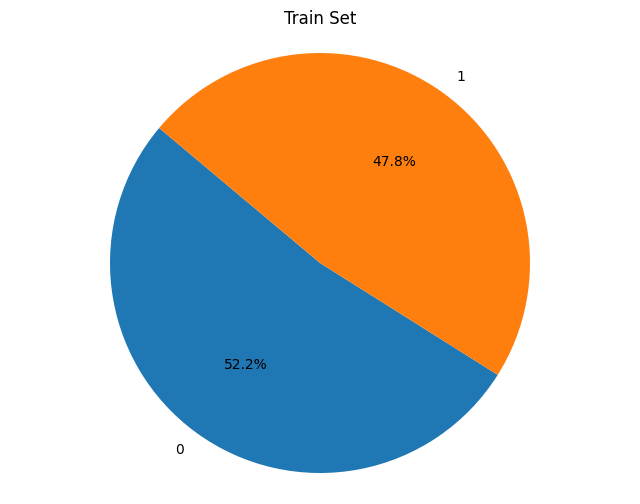

Number of documents are 6920


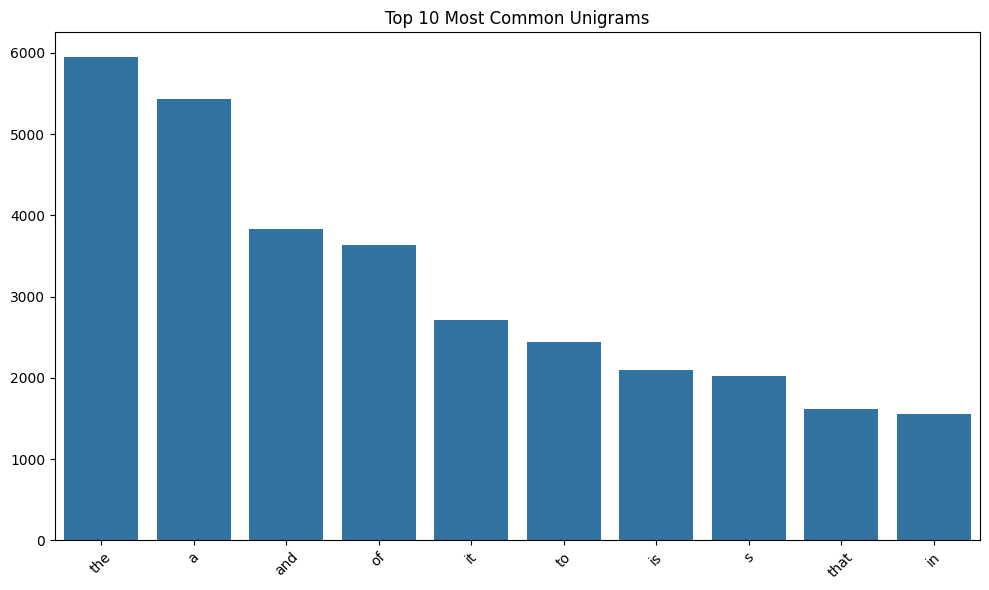

In [6]:
print("Statistics for training set:")
train_statistics = get_statistics(ds_train)
plot_distribution(train_statistics["label_distribution"],"Train Set")
print(f"Number of documents are {train_statistics['document_count']}")
plot_unigrams(train_statistics["unigram_count"])


It is seen that top words in unigram are not distinctive words in terms of context. Applying stop words is a good choice.

### Unigrams below are obtained after removing stop words, which is expected to have better effect on the model's learning

applying stop words
unigram after stop words


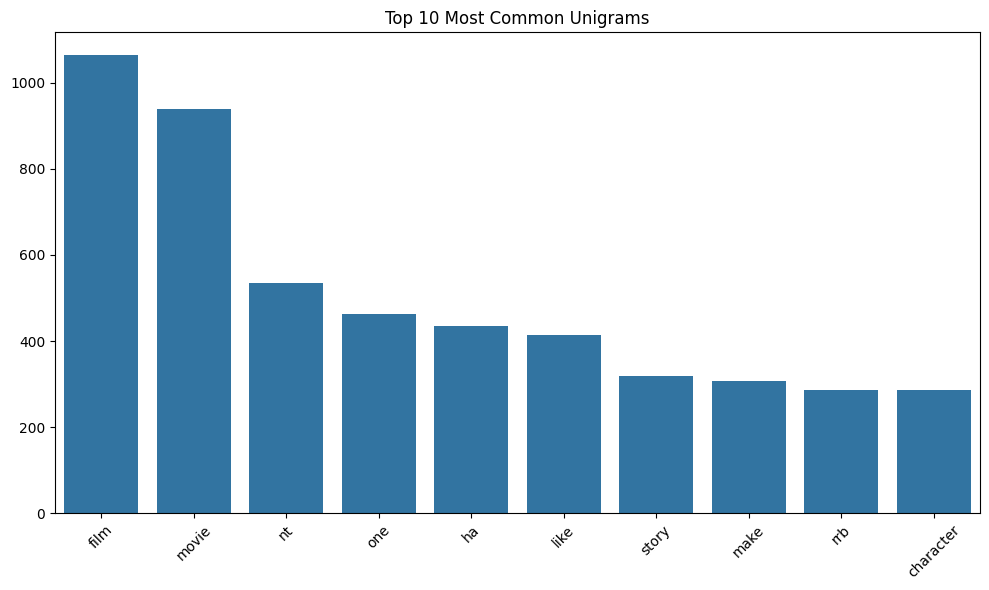

In [7]:
print("applying stop words")
ds_train = remove_stop_words(ds_train)
train_statistics = get_statistics(ds_train)
print("unigram after stop words")
plot_unigrams(train_statistics["unigram_count"])

Statistics for validation set:


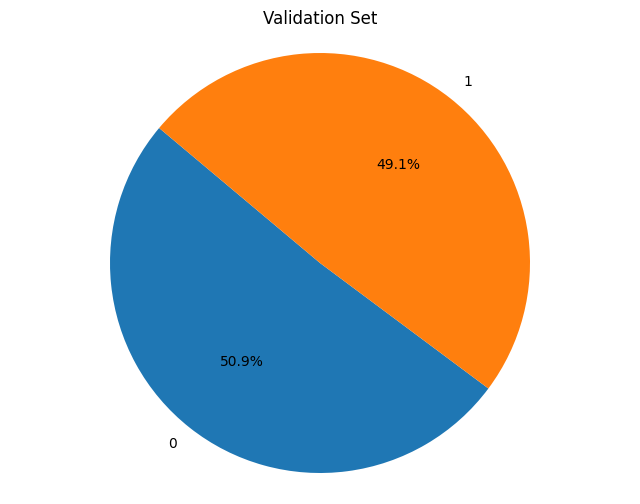

Number of documents are 872
Statistics for test set:


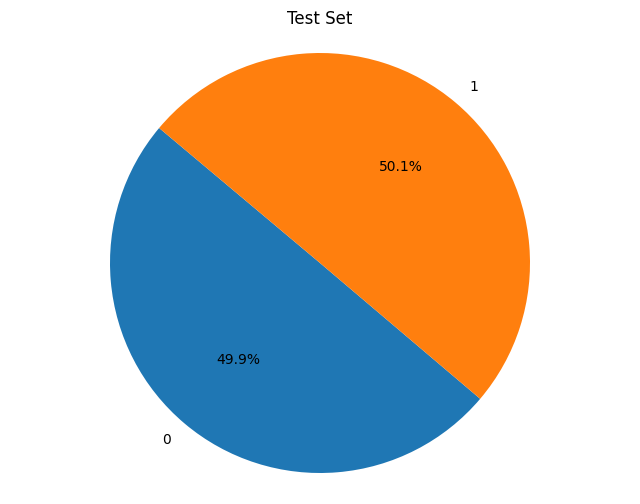

Number of documents are 1821


In [8]:
#remove stop words for val and test set and print statistics
remove_stop_words(ds_val)
remove_stop_words(ds_test)

print("Statistics for validation set:")
val_statistics = get_statistics(ds_val)
plot_distribution(val_statistics["label_distribution"],"Validation Set")
print(f"Number of documents are {val_statistics['document_count']}")

print("Statistics for test set:")
test_statistics = get_statistics(ds_test)
plot_distribution(test_statistics["label_distribution"],"Test Set")
print(f"Number of documents are {test_statistics['document_count']}")

### Choosing an Appropriate Evaluation Metric

From the distributions of the dataset above, it can be seen that the dataset is balanced. Hence accuracy serves as an appropriate metric.

Also for our task, sentiment classification for movie reviews, we are not strictly interested in semantic importance of recall (like in a medical task) or semantic importance of precision (like in a spam detection). Therefore accuracy serves as an appropriate metric 

### VECTORIZATION
To feed the data into the model, strings need to be vectorized. There are couple of ways for this. Here TF-IDF and Count Vectorizer are used.

In [9]:
# train the classifier with 2 vectorization tech.
tfidf_vectorizer = TfidfVectorizer(preprocessor=lambda x: x, tokenizer=lambda x: x) # disable preprocessing as preprocessing is already done
count_vectorizer = CountVectorizer(preprocessor=lambda x: x, tokenizer=lambda x: x)

# vectorize all splits to fed into the model

tfidf_train = tfidf_vectorizer.fit_transform(ds_train['text'])
count_vect_train = count_vectorizer.fit_transform(ds_train["text"])

tfidf_val = tfidf_vectorizer.transform(ds_val["text"])
count_vect_val = count_vectorizer.transform(ds_val["text"])

tfidf_test = tfidf_vectorizer.transform(ds_test["text"])
count_vect_test = count_vectorizer.transform(ds_test["text"])

C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


### MODEL 1 NAIVE BAYES

In [10]:
# train the models
NB_classifier_tfidf = MultinomialNB().fit(tfidf_train, ds_train["label"])
NB_classifier_count_vect = MultinomialNB().fit(count_vect_train, ds_train["label"])

# make predictions
tfidf_val_predictions = NB_classifier_tfidf.predict(tfidf_val)
count_vect_val_predictions = NB_classifier_count_vect.predict(count_vect_val)

In [11]:
# get metrics
tfidf_metrics = calculate_metrics(tfidf_val_predictions,ds_val["label"],"tfidf")
count_vect_metrics = calculate_metrics(count_vect_val_predictions,ds_val["label"],"count vectorization")

In [12]:
total_metrics = list()
total_metrics.append(tfidf_metrics)
total_metrics.append(count_vect_metrics)

comparison_df = pd.DataFrame.from_records(total_metrics)
# Sort the values according to our metric
comparison_df = comparison_df.sort_values(by = "accuracy", ascending = False)

print(comparison_df)


   accuracy  f1_score  precision   recall                 mode
1   0.78555  0.785363   0.785923  0.78555  count vectorization
0   0.78211  0.780947   0.786342  0.78211                tfidf


### COMPARISON ANALYSIS in Naive Bayes

From the results above, it can be seen that count vectorization performed slightly (% 0.38 ) better. 
Actually TF-IDF is a more advanced technique because it not only focuses on the frequency of words present in the corpus but also provides the importance of the words.

The performance difference between Count Vectorizer and TF-IDF is not substantial, but the slightly better performance of Count Vectorizer could be attributed to specific characteristics of the dataset. These include:

**Short Document**s: If the dataset consists of shorter documents, the raw frequency counts provided by Count Vectorizer might be more effective than TF-IDF's weighted scores.

**Rare Words as Noise**: In some datasets, rare words might introduce noise rather than valuable information. TF-IDF tends to emphasize these rare words, which can negatively impact performance.

### PREDICTION ON TEST SET using Naive Bayes

In [13]:
test_set_results = list()

count_vect_test_predictions = NB_classifier_count_vect.predict(count_vect_test)
metrics = calculate_metrics(count_vect_test_predictions,ds_test["label"],"Naive Bayes Using Count Vectorization")
print(metrics)
test_set_results.append(metrics)

{'accuracy': 0.814387699066447, 'f1_score': 0.81407665508389, 'precision': 0.8166186066419386, 'recall': 0.814387699066447, 'mode': 'Naive Bayes Using Count Vectorization'}


### MODEL 2 RNN

RNNs excel in capturing patterns and dependencies in sequential data. They are broadly used in NLP tasks.

I wanted to investigate how it behaves with vectorization techniques TF-IDF and Count Vectorizer and wanted to compare it with Naive Bayes.

In order to compare vectorization techniques, RNN architecture used is same in both. For simplicity I used Simple RNN and a Dense layer. For the optimizer, Adam is used for it's reduced need for manual hand tuning.

In [14]:
def reshape(ds):
    return ds[:,np.newaxis,:]

In [15]:
# reshape inputs
X_train_tfidf_rnn = tfidf_train.toarray()
X_val_tfidf_rnn = tfidf_val.toarray()
X_test_tfidf_rnn = tfidf_test.toarray()

X_train_count_vect_rnn = count_vect_train.toarray()
X_train_count_vect_rnn = count_vect_train.toarray()
X_val_count_vect_rnn = count_vect_val.toarray()
X_test_count_vect_rnn = count_vect_test.toarray()

y_train_rnn = np.array(ds_train["label"])
y_val_rnn = np.array(ds_val["label"])
y_test_rnn = np.array(ds_test["label"])

# Reshape the TF-IDF and Count Vectorizor vectors
X_train_tfidf_rnn = reshape(X_train_tfidf_rnn)
X_val_tfidf_rnn = reshape(X_val_tfidf_rnn)
X_test_tfidf_rnn = reshape(X_test_tfidf_rnn)
X_train_count_vect_rnn = reshape(X_train_count_vect_rnn)
X_val_count_vect_rnn = reshape(X_val_count_vect_rnn )
X_test_count_vect_rnn = reshape(X_test_count_vect_rnn)

### RNN with TF-IDF

In [16]:
# Define the RNN model
model_tfidf = Sequential()
model_tfidf.add(SimpleRNN(units=50, input_shape=(1, X_train_tfidf_rnn.shape[2])))
model_tfidf.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model_tfidf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model_tfidf.fit(X_train_tfidf_rnn, y_train_rnn, epochs=7, batch_size=1)

C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/7
6920/6920 ━━━━━━━━━━━━━━━━━━━━ 48s 7ms/step - accuracy: 0.6871 - loss: 0.5824
Epoch 2/7
6920/6920 ━━━━━━━━━━━━━━━━━━━━ 46s 7ms/step - accuracy: 0.9257 - loss: 0.2007
Epoch 3/7
6920/6920 ━━━━━━━━━━━━━━━━━━━━ 47s 7ms/step - accuracy: 0.9641 - loss: 0.1020
Epoch 4/7
6920/6920 ━━━━━━━━━━━━━━━━━━━━ 47s 7ms/step - accuracy: 0.9798 - loss: 0.0594
Epoch 5/7
6920/6920 ━━━━━━━━━━━━━━━━━━━━ 47s 7ms/step - accuracy: 0.9887 - loss: 0.0345
Epoch 6/7
6920/6920 ━━━━━━━━━━━━━━━━━━━━ 47s 7ms/step - accuracy: 0.9924 - loss: 0.0250
Epoch 7/7
6920/6920 ━━━━━━━━━━━━━━━━━━━━ 47s 7ms/step - accuracy: 0.9959 - loss: 0.0132


In [17]:
# test the model
predictions = model_tfidf.predict(X_val_tfidf_rnn)

# Convert probabilities to binary labels
threshold = 0.5
predictions = (predictions > threshold).astype(int)

metrics = calculate_metrics(predictions,y_val_rnn,"rnn tfidf epochs 7")
print(metrics)


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
{'accuracy': 0.7488532110091743, 'f1_score': 0.7483174412652642, 'precision': 0.7499396340354482, 'recall': 0.7488532110091743, 'mode': 'rnn tfidf epochs 7'}


### RNN with Count Vectorizer

In [18]:
# Define the RNN model
model_count_vect = Sequential()
model_count_vect.add(SimpleRNN(units=50, input_shape=(1, X_train_count_vect_rnn.shape[2])))
model_count_vect.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model_count_vect.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model_count_vect.fit(X_train_count_vect_rnn, y_train_rnn, epochs=7, batch_size=1)

C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/7
6920/6920 ━━━━━━━━━━━━━━━━━━━━ 49s 7ms/step - accuracy: 0.6921 - loss: 0.5763
Epoch 2/7
6920/6920 ━━━━━━━━━━━━━━━━━━━━ 47s 7ms/step - accuracy: 0.9110 - loss: 0.2175
Epoch 3/7
6920/6920 ━━━━━━━━━━━━━━━━━━━━ 47s 7ms/step - accuracy: 0.9567 - loss: 0.1144
Epoch 4/7
6920/6920 ━━━━━━━━━━━━━━━━━━━━ 47s 7ms/step - accuracy: 0.9791 - loss: 0.0646
Epoch 5/7
6920/6920 ━━━━━━━━━━━━━━━━━━━━ 47s 7ms/step - accuracy: 0.9837 - loss: 0.0447
Epoch 6/7
6920/6920 ━━━━━━━━━━━━━━━━━━━━ 47s 7ms/step - accuracy: 0.9895 - loss: 0.0299
Epoch 7/7
6920/6920 ━━━━━━━━━━━━━━━━━━━━ 48s 7ms/step - accuracy: 0.9923 - loss: 0.0231


In [19]:
# test the model
predictions = model_count_vect.predict(X_val_count_vect_rnn)

# Convert probabilities to binary labels
threshold = 0.5
predictions = (predictions > threshold).astype(int)

metrics = calculate_metrics(predictions,y_val_rnn,"rnn count vect. epochs 7")
print(metrics)

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
{'accuracy': 0.7522935779816514, 'f1_score': 0.7522675030724935, 'precision': 0.7522730996068152, 'recall': 0.7522935779816514, 'mode': 'rnn count vect. epochs 7'}


### Comparison for RNN for TFIDF vs Count Vect.
Count Vectorizer performed % 1.33 better than TF-IDF on RNN. Count vectorizer also performed slightly better comparing to TF-IDF on Naive Bayes. The potential reasons were discussed above in Naive Bayes comparison.

### Let's increase epoch size to see how the model behaves

In [20]:
# Define the RNN model
model = Sequential()
model.add(SimpleRNN(units=50, input_shape=(1, X_train_count_vect_rnn.shape[2])))
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_count_vect_rnn, y_train_rnn, epochs=15, batch_size=1)

C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
6920/6920 ━━━━━━━━━━━━━━━━━━━━ 49s 7ms/step - accuracy: 0.6772 - loss: 0.5778
Epoch 2/15
6920/6920 ━━━━━━━━━━━━━━━━━━━━ 48s 7ms/step - accuracy: 0.9218 - loss: 0.2113
Epoch 3/15
6920/6920 ━━━━━━━━━━━━━━━━━━━━ 48s 7ms/step - accuracy: 0.9547 - loss: 0.1229
Epoch 4/15
6920/6920 ━━━━━━━━━━━━━━━━━━━━ 48s 7ms/step - accuracy: 0.9726 - loss: 0.0751
Epoch 5/15
6920/6920 ━━━━━━━━━━━━━━━━━━━━ 48s 7ms/step - accuracy: 0.9850 - loss: 0.0426
Epoch 6/15
6920/6920 ━━━━━━━━━━━━━━━━━━━━ 48s 7ms/step - accuracy: 0.9890 - loss: 0.0306
Epoch 7/15
6920/6920 ━━━━━━━━━━━━━━━━━━━━ 48s 7ms/step - accuracy: 0.9914 - loss: 0.0212
Epoch 8/15
6920/6920 ━━━━━━━━━━━━━━━━━━━━ 49s 7ms/step - accuracy: 0.9951 - loss: 0.0128
Epoch 9/15
6920/6920 ━━━━━━━━━━━━━━━━━━━━ 48s 7ms/step - accuracy: 0.9976 - loss: 0.0087
Epoch 10/15
6920/6920 ━━━━━━━━━━━━━━━━━━━━ 47s 7ms/step - accuracy: 0.9975 - loss: 0.0073
Epoch 11/15
6920/6920 ━━━━━━━━━━━━━━━━━━━━ 47s 7ms/step - accuracy: 0.9978 - loss: 0.0065
Epoch 12/15
6920/69

In [21]:
# test the model
predictions = model.predict(X_val_count_vect_rnn)

# Convert probabilities to binary labels
threshold = 0.5
predictions = (predictions > threshold).astype(int)

metrics = calculate_metrics(predictions,y_val_rnn,"rnn count vect. epochs 15")
print(metrics)

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
{'accuracy': 0.7282110091743119, 'f1_score': 0.7276887068567295, 'precision': 0.7290165619256933, 'recall': 0.7282110091743119, 'mode': 'rnn count vect. epochs 15'}


As seen from the results above, increasing the epoch size reduced the accuracy probably due to overfitting. Also, an increase was not  expected because the theoratical problem was the vectorization technique.

### PREDICTION ON TEST SET using RNN with the best observed technique.

In [22]:
# test the model
predictions_test_rnn = model_count_vect.predict(X_test_count_vect_rnn)

# Convert probabilities to binary labels
threshold = 0.5
predictions_test_rnn = (predictions_test_rnn > threshold).astype(int)

rnn_metrics = calculate_metrics(predictions_test_rnn,y_test_rnn,"rnn count vect. epochs 7")
print(rnn_metrics)

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
{'accuracy': 0.7677100494233937, 'f1_score': 0.767697439806417, 'precision': 0.7677890299658081, 'recall': 0.7677100494233937, 'mode': 'rnn count vect. epochs 7'}


### FINAL SECTION
### COMPARISON OF RESULTS OF THE TWO MODELS

In [23]:
test_set_results.append(rnn_metrics)

comparison_df = pd.DataFrame.from_records(test_set_results)
# Sort the values according to our metric
comparison_df = comparison_df.sort_values(by = "accuracy", ascending = False)

print(comparison_df)

   accuracy  f1_score  precision    recall  \
0  0.814388  0.814077   0.816619  0.814388   
1  0.767710  0.767697   0.767789  0.767710   

                                    mode  
0  Naive Bayes Using Count Vectorization  
1               rnn count vect. epochs 7  


**Confusion Matrix**

Since it is a binary classification task, I found it hard to make conclusions from confusion matrixes. If it were a multiclass classification
It would be more practical to come up with a comparison.

Confusion Matrix for RNN


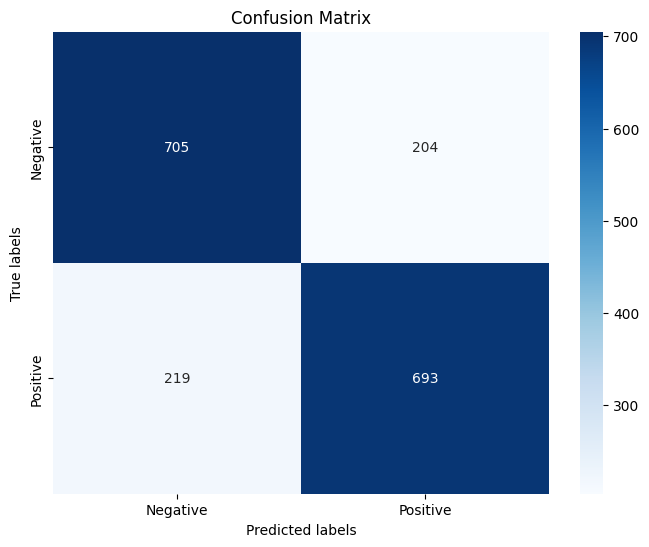

Confusion Matrix for Naive Bayes


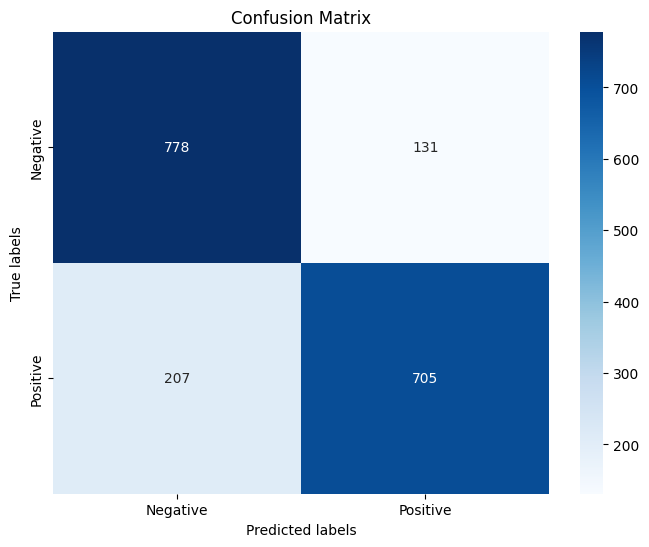

In [24]:
print("Confusion Matrix for RNN")
plot_cm(predictions_test_rnn,y_test_rnn)
print("Confusion Matrix for Naive Bayes")
plot_cm(count_vect_test_predictions,ds_test["label"])


**Performance Wise**

Using accuracy as our metric (reasons were discussed above) Naive Bayes (with Count Vectorization) performed %7 better than RNN (with Count Vectorization)

As seen from the results, accuracy decreased on RNN comparing to Naive Bayes. However RNN's are known to be quite good for NLP tasks
so the result might seem unexpected.

This is because vectorization techniques that were used does not leverage the strengths of RNNs in processing sequences. RNNs are designed to capture sequential dependencies in data, but TF-IDF and Count Vectorizer transform the text into a bag-of-words representation, losing the sequential information. This mismatch can hinder the performance of RNNs. 

For RNNs, word embeddings like Word2Vec are better suited. Although it also does not preserve order, it preserves the contextual information and as a conclusion sequential information within the text.

**Computation Wise**

I didn't do a benchmark test but it can be understood from the run time of kernels that Naive Bayes is simple to implement and computationally efficient, requiring less training data compared to RNN. Which was theoratically known.

**Final Conclusion**

In conclusion, Naive Bayes is simple to implement and computationally efficient compared to RNNs, making it a suitable baseline for many NLP tasks.
While RNNs are powerful tools, leveraging their strengths requires the use of appropriate vectorization techniques.

Additionally, although TF-IDF is a more advanced technique compared to Count Vectorizer, its advantages may not be fully realized based on the dataset characteristics (short documents and noise etc.) as with our case.


### RNN with WORD2VEC
Word2VEC is a good choice to utilize RNN's strengths but I couldn't make it run due to the error I couldn't solve:

(Popular bug when importing: https://stackoverflow.com/questions/78279136/importerror-cannot-import-name-triu-from-scipy-linalg-when-importing-gens when trying to solve it I ran into an another bug as seen: Cannot import name 'Mapping' from 'collections')

But I wanted to include the source code.

In [25]:
# !pip install gensim
# !pip install numpy 
# !pip install tensorflow


In [31]:
# import numpy as np
# import gensim
# from gensim.models import Word2Vec
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# # from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Embedding, SimpleRNN, Dense


ImportError: cannot import name 'Mapping' from 'collections' (C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\collections\__init__.py)

In [ ]:
# # Tokenize the text
# train_tokenized_texts = ds_train["test"]
# test_tokenized_texts = ds_train["val"]

# # Train Word2Vec model
# word2vec_model = Word2Vec(sentences=train_tokenized_texts, vector_size=100, window=5, min_count=1, workers=4)

# # Save the model (optional)
# word2vec_model.save("word2vec.model")

# # Create a dictionary to map words to their Word2Vec vectors
# word_index = {word: idx + 1 for idx, word in enumerate(word2vec_model.wv.index_to_key)}
# embedding_matrix = np.zeros((len(word_index) + 1, word2vec_model.vector_size))

# for word, i in word_index.items():
#     embedding_matrix[i] = word2vec_model.wv[word]

# # Convert texts to sequences of indices
# train_sequences = [[word_index[word] for word in text if word in word_index] for text in train_tokenized_texts]
# test_sequences = [[word_index[word] for word in text if word in word_index] for text in test_tokenized_texts]

# # Pad sequences
# max_length = max(max(len(seq) for seq in train_sequences), max(len(seq) for seq in test_sequences))
# train_padded_sequences = pad_sequences(train_sequences, maxlen=max_length, padding='post')
# test_padded_sequences = pad_sequences(test_sequences, maxlen=max_length, padding='post')

# # Convert labels to numpy array
# train_labels = np.array(ds_train["label"])
# test_labels = np.array(ds_val["label"])

# # Define the RNN model
# model = Sequential()
# model.add(Embedding(input_dim=len(word_index) + 1, output_dim=word2vec_model.vector_size, weights=[embedding_matrix], input_length=max_length, trainable=False))
# model.add(SimpleRNN(128))
# model.add(Dense(1, activation='sigmoid'))

# # Compile the model
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# # Train the model
# model.fit(train_padded_sequences, train_labels, epochs=10, batch_size=2)

# # Evaluate the model on training data
# train_loss, train_accuracy = model.evaluate(train_padded_sequences, train_labels)
# print(f"Training Accuracy: {train_accuracy}")

# # Evaluate the model on test data
# test_loss, test_accuracy = model.evaluate(test_padded_sequences, test_labels)
# print(f"Test Accuracy: {test_accuracy}")

# # Predict sentiments for test data
# predictions = model.predict(test_padded_sequences)
# predictions = (predictions > 0.5).astype(int)  # Convert probabilities to binary output
# print(f"Predictions: {predictions.flatten()}")
# print(f"Actual labels: {test_labels}")